In [2]:
import os
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

In [3]:
# training_dataset_paths = {
#     "for-norm-real": ("/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/real", 0, 12015),  
#     "for-norm-fake": ("/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/fake", 1, 12015),  
#     "for-2s-real": ("/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/real", 0, 6978),       
#     "for-2s-fake": ("/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/fake", 1, 6978),       
#     "for-rerecording-real": ("/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/training/real", 0, 5104),  
#     "for-rerecording-fake": ("/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/training/fake", 1, 5104),  
# }
training_dataset_paths = {
    "for-norm-real": ("/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/real", 0, 3000),  
    "for-norm-fake": ("/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/fake", 1, 3000),  
    "for-2s-real": ("/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/real", 0, 2000),       
    "for-2s-fake": ("/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/fake", 1, 2000),       
    "for-rerecording-real": ("/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/training/real", 0, 1500),  
    "for-rerecording-fake": ("/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/training/fake", 1, 1500),  
}

In [4]:
# testing_dataset_paths = {
#     "for-norm-real": ("/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing/real", 0, 2264),  
#     "for-norm-fake": ("/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing/fake", 1, 2370),  
#     "for-2s-real": ("/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/testing/real", 0, 544),       
#     "for-2s-fake": ("/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/testing/fake", 1, 544),       
#     "for-rerecording-real": ("/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/testing/real", 0, 408),  
#     "for-rerecording-fake": ("/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/testing/fake", 1, 408),  
# }
testing_dataset_paths = {
    "for-norm-real": ("/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing/real", 0, 1000),  
    "for-norm-fake": ("/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing/fake", 1, 1000),  
    "for-2s-real": ("/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/testing/real", 0, 250),       
    "for-2s-fake": ("/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/testing/fake", 1, 250),       
    "for-rerecording-real": ("/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/testing/real", 0, 200),  
    "for-rerecording-fake": ("/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/testing/fake", 1, 200),  
}

In [5]:
# validation_dataset_paths = {
#     "for-norm-real": ("/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/validation/real", 0, 5400),  
#     "for-norm-fake": ("/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/validation/fake", 1, 5398),  
#     "for-2s-real": ("/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/validation/real", 0, 1413),       
#     "for-2s-fake": ("/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/validation/fake", 1, 1413),       
#     "for-rerecording-real": ("/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/validation/real", 0, 1101),  
#     "for-rerecording-fake": ("/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/validation/fake", 1, 1143),  
# }
validation_dataset_paths = {
    "for-norm-real": ("/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/validation/real", 0, 1500),  
    "for-norm-fake": ("/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/validation/fake", 1, 1500),  
    "for-2s-real": ("/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/validation/real", 0, 500),       
    "for-2s-fake": ("/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/validation/fake", 1, 500),       
    "for-rerecording-real": ("/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/validation/real", 0, 500),  
    "for-rerecording-fake": ("/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/validation/fake", 1, 500),  
}


In [6]:
def process_audio_files(directory, label, limit=None, sample_rate=22050, n_mels=224):
    """
    Load audio files from the directory, convert them to mel spectrograms, and assign labels.
    Args:
        directory (str): Path to the directory containing audio files.
        label (int): Label for the audio files (0 for real, 1 for fake).
        limit (int, optional): Number of files to load. If None, load all files.
        sample_rate (int): Sampling rate for audio loading.
        n_mels (int): Number of mel filters for the spectrogram.
    Returns:
        np.ndarray: Array of processed mel spectrograms.
        np.ndarray: Array of labels.
    """
    data = []
    labels = []

    # Get all files in the directory
    all_files = os.listdir(directory)
    if limit is not None:
        # Select only `limit` number of files
        all_files = all_files[:limit]

    for file_name in tqdm(all_files, desc=f"Processing {directory}"):
        file_path = os.path.join(directory, file_name)
        try:
            # Load audio file
            audio, sr = librosa.load(file_path, sr=sample_rate)
            
            # Convert to mel spectrogram
            mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512, n_mels=n_mels)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            
            # Normalize and resize to 224x224
            mel_spec_db = librosa.util.normalize(mel_spec_db)
            if mel_spec_db.shape != (224, 224):
                mel_spec_db = librosa.util.fix_length(mel_spec_db, size=224, axis=0)
                mel_spec_db = librosa.util.fix_length(mel_spec_db, size=224, axis=1)
            
            data.append(mel_spec_db)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
    
    return np.array(data), np.array(labels)

In [7]:
# Process datasets and combine them
X_train, y_train = [], []
for subset_name, (path, label, limit) in training_dataset_paths.items():
    print(f"Processing subset: {subset_name}")
    data, labels = process_audio_files(path, label, limit)
    X_train.extend(data)
    y_train.extend(labels)

# Convert combined data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Print the shapes of the combined dataset
print(f"Combined dataset shape: {X_train.shape}, {y_train.shape}")

Processing subset: for-norm-real


Processing /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/real: 100%|██████████| 3000/3000 [02:34<00:00, 19.44it/s]


Processing subset: for-norm-fake


Processing /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/fake: 100%|██████████| 3000/3000 [01:41<00:00, 29.59it/s]


Processing subset: for-2s-real


Processing /kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/real: 100%|██████████| 2000/2000 [01:06<00:00, 30.22it/s]


Processing subset: for-2s-fake


Processing /kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/fake: 100%|██████████| 2000/2000 [01:15<00:00, 26.49it/s]


Processing subset: for-rerecording-real


Processing /kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/training/real: 100%|██████████| 1500/1500 [00:57<00:00, 26.28it/s]


Processing subset: for-rerecording-fake


Processing /kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/training/fake: 100%|██████████| 1500/1500 [00:56<00:00, 26.49it/s]


Combined dataset shape: (13000, 224, 224), (13000,)


In [8]:
# Process datasets and combine them
X_test, y_test = [], []
for subset_name, (path, label, limit) in testing_dataset_paths.items():
    print(f"Processing subset: {subset_name}")
    data, labels = process_audio_files(path, label, limit)
    X_test.extend(data)
    y_test.extend(labels)

# Convert combined data to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Print the shapes of the combined dataset
print(f"Combined dataset shape: {X_test.shape}, {y_test.shape}")

Processing subset: for-norm-real


Processing /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing/real: 100%|██████████| 1000/1000 [00:36<00:00, 27.37it/s]


Processing subset: for-norm-fake


Processing /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing/fake: 100%|██████████| 1000/1000 [00:33<00:00, 30.02it/s]


Processing subset: for-2s-real


Processing /kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/testing/real: 100%|██████████| 250/250 [00:08<00:00, 28.31it/s]


Processing subset: for-2s-fake


Processing /kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/testing/fake: 100%|██████████| 250/250 [00:07<00:00, 33.80it/s]


Processing subset: for-rerecording-real


Processing /kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/testing/real: 100%|██████████| 200/200 [00:06<00:00, 28.71it/s]


Processing subset: for-rerecording-fake


Processing /kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/testing/fake: 100%|██████████| 200/200 [00:07<00:00, 28.33it/s]


Combined dataset shape: (2900, 224, 224), (2900,)


In [9]:
# Process datasets and combine them
X_val, y_val = [], []
for subset_name, (path, label, limit) in validation_dataset_paths.items():
    print(f"Processing subset: {subset_name}")
    data, labels = process_audio_files(path, label, limit)
    X_val.extend(data)
    y_val.extend(labels)

# Convert combined data to numpy arrays
X_val = np.array(X_val)
y_val = np.array(y_val)

# Print the shapes of the combined dataset
print(f"Combined dataset shape: {X_val.shape}, {y_val.shape}")

Processing subset: for-norm-real


Processing /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/validation/real: 100%|██████████| 1500/1500 [01:06<00:00, 22.42it/s]


Processing subset: for-norm-fake


Processing /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/validation/fake: 100%|██████████| 1500/1500 [00:50<00:00, 29.47it/s]


Processing subset: for-2s-real


Processing /kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/validation/real: 100%|██████████| 500/500 [00:16<00:00, 30.40it/s]


Processing subset: for-2s-fake


Processing /kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/validation/fake: 100%|██████████| 500/500 [00:16<00:00, 30.41it/s]


Processing subset: for-rerecording-real


Processing /kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/validation/real: 100%|██████████| 500/500 [00:19<00:00, 25.92it/s]


Processing subset: for-rerecording-fake


Processing /kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/validation/fake: 100%|██████████| 500/500 [00:18<00:00, 26.95it/s]


Combined dataset shape: (5000, 224, 224), (5000,)


In [10]:
# import numpy as np

# # Save all arrays into a single compressed file
# np.savez_compressed('melspectograms.npz', 
#                     X_train=X_train, X_test=X_test, X_val=X_val, 
#                     y_train=y_train, y_test=y_test, y_val=y_val)

# print("Datasets compressed into melspectograms.npz.")


In [11]:
def visualize_real_and_fake_samples(X, y, num_samples=1):
    """
    Visualize a mix of real and fake samples with their labels.

    Args:
        X (np.ndarray): Array of mel spectrograms.
        y (np.ndarray): Array of labels.
        num_samples (int): Number of samples for each class (real and fake) to visualize.
    """
    real_samples = X[y == 0]
    fake_samples = X[y == 1]

    plt.figure(figsize=(15, 10))

    for i in range(num_samples):
        # Real samples
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(real_samples[i], cmap='magma', aspect='auto')
        plt.title("Real")
        plt.axis('off')

        # Fake samples
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(fake_samples[i], cmap='magma', aspect='auto')
        plt.title("Fake")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

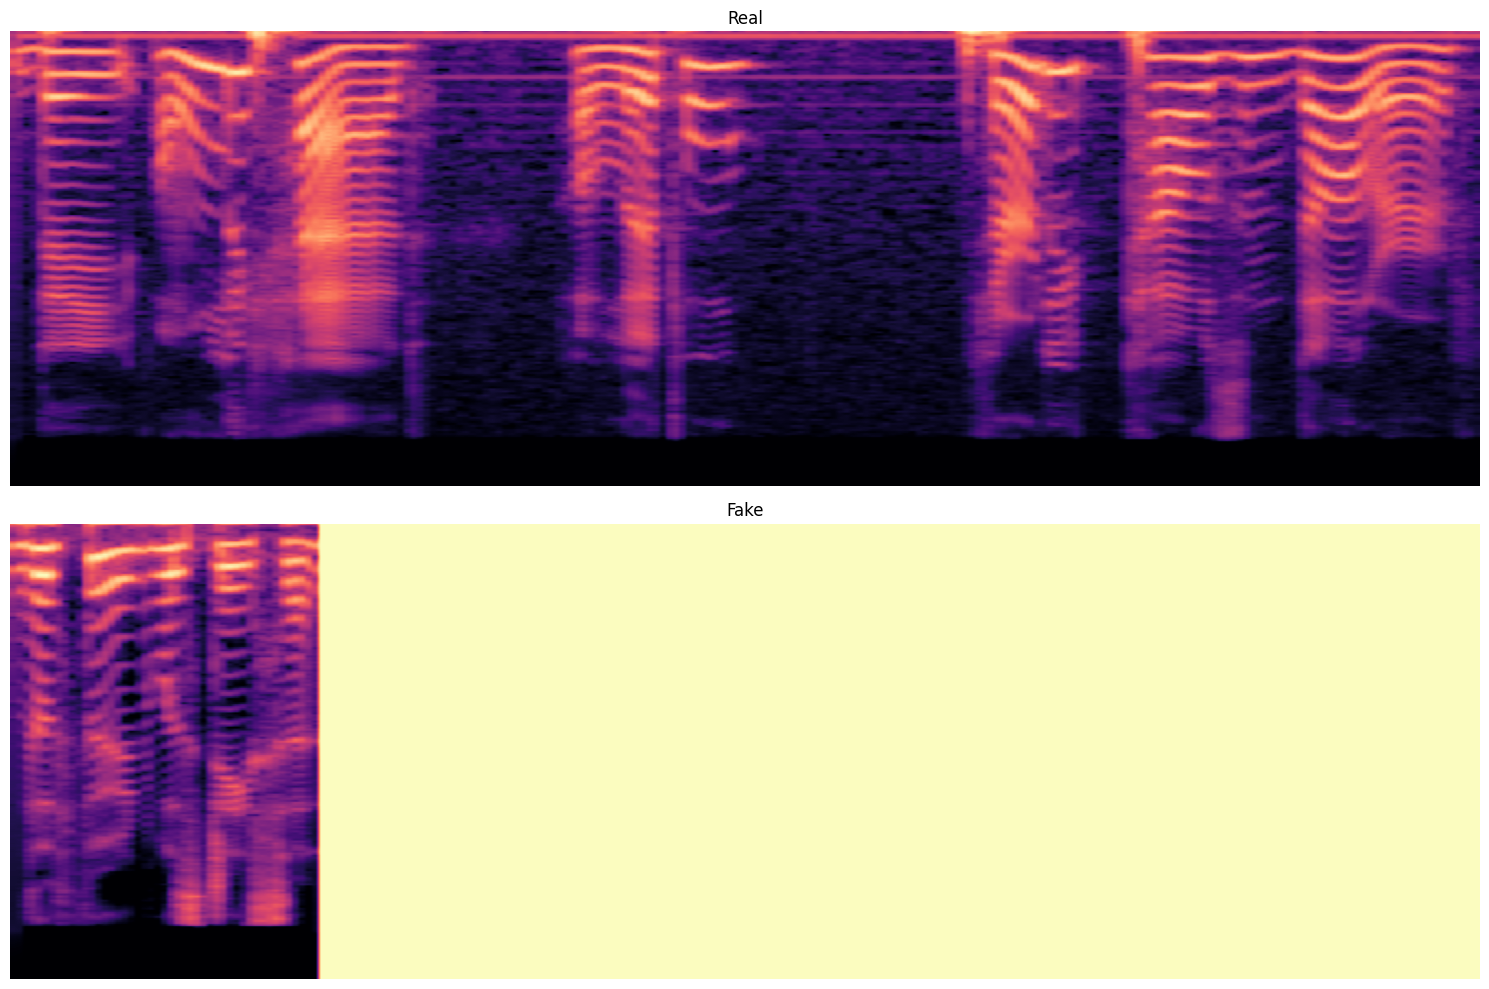

In [12]:
visualize_real_and_fake_samples(X_train, y_train)

In [13]:
# Add a single channel first
X_train = np.expand_dims(X_train, axis=-1)  # Shape becomes (height, width, 1)

# Repeat the channel dimension 3 times to create 3 channels
X_train = np.repeat(X_train, 3, axis=-1)  # Shape becomes (height, width, 3)

print(f"Expanded X_train shape: {X_train.shape}")


Expanded X_train shape: (13000, 224, 224, 3)


In [14]:
# Add a single channel first
X_test = np.expand_dims(X_test, axis=-1)  # Shape becomes (height, width, 1)

# Repeat the channel dimension 3 times to create 3 channels
X_test = np.repeat(X_test, 3, axis=-1)  # Shape becomes (height, width, 3)

print(f"Expanded X_test shape: {X_test.shape}")


Expanded X_test shape: (2900, 224, 224, 3)


In [15]:
# Add a single channel first
X_val = np.expand_dims(X_val, axis=-1)  # Shape becomes (height, width, 1)

# Repeat the channel dimension 3 times to create 3 channels
X_val = np.repeat(X_val, 3, axis=-1)  # Shape becomes (height, width, 3)

print(f"Expanded X_val shape: {X_val.shape}")


Expanded X_val shape: (5000, 224, 224, 3)


In [16]:
# Load the pre-trained VGG16 model without the top layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



# Freeze the initial layers
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom layers for binary classification
x = vgg_base.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)  # Fully connected layer with 256 neurons
x = Dropout(0.5)(x)                   # Dropout layer with 50% ratio
x = Dense(1, activation='sigmoid')(x)  # Final dense layer with 2 neurons (SoftMax)


# Create the final model
model = Model(inputs=vgg_base.input, outputs=x)
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)



In [18]:
#Train the model
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=20, 
    batch_size=32, 
    verbose=1
)

Epoch 1/20


I0000 00:00:1734463965.381342     112 service.cc:145] XLA service 0x7ac480001180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734463965.381453     112 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734463965.381467     112 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/407 ━━━━━━━━━━━━━━━━━━━━ 1:55:57 17s/step - accuracy: 0.3125 - loss: 0.9213

I0000 00:00:1734463981.037869     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


407/407 ━━━━━━━━━━━━━━━━━━━━ 104s 214ms/step - accuracy: 0.7274 - loss: 0.8421 - val_accuracy: 0.8426 - val_loss: 0.3376
Epoch 2/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 80s 198ms/step - accuracy: 0.8606 - loss: 0.3135 - val_accuracy: 0.9222 - val_loss: 0.2194
Epoch 3/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 80s 197ms/step - accuracy: 0.8676 - loss: 0.2839 - val_accuracy: 0.9316 - val_loss: 0.1931
Epoch 4/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 80s 196ms/step - accuracy: 0.8920 - loss: 0.2542 - val_accuracy: 0.9196 - val_loss: 0.2125
Epoch 5/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 80s 197ms/step - accuracy: 0.8836 - loss: 0.2557 - val_accuracy: 0.9414 - val_loss: 0.1478
Epoch 6/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 80s 197ms/step - accuracy: 0.8943 - loss: 0.2259 - val_accuracy: 0.9342 - val_loss: 0.1852
Epoch 7/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 80s 197ms/step - accuracy: 0.8848 - loss: 0.2570 - val_accuracy: 0.9292 - val_loss: 0.2162
Epoch 8/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 80s 198ms/step - accuracy: 0.8926 - loss: 0.2539 - va

In [19]:
model.save("testing.h5")

In [20]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32, verbose=1)

# Print the results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


91/91 ━━━━━━━━━━━━━━━━━━━━ 26s 284ms/step - accuracy: 0.8401 - loss: 0.4774
Test Loss: 0.4803101420402527
Test Accuracy: 0.8231034278869629


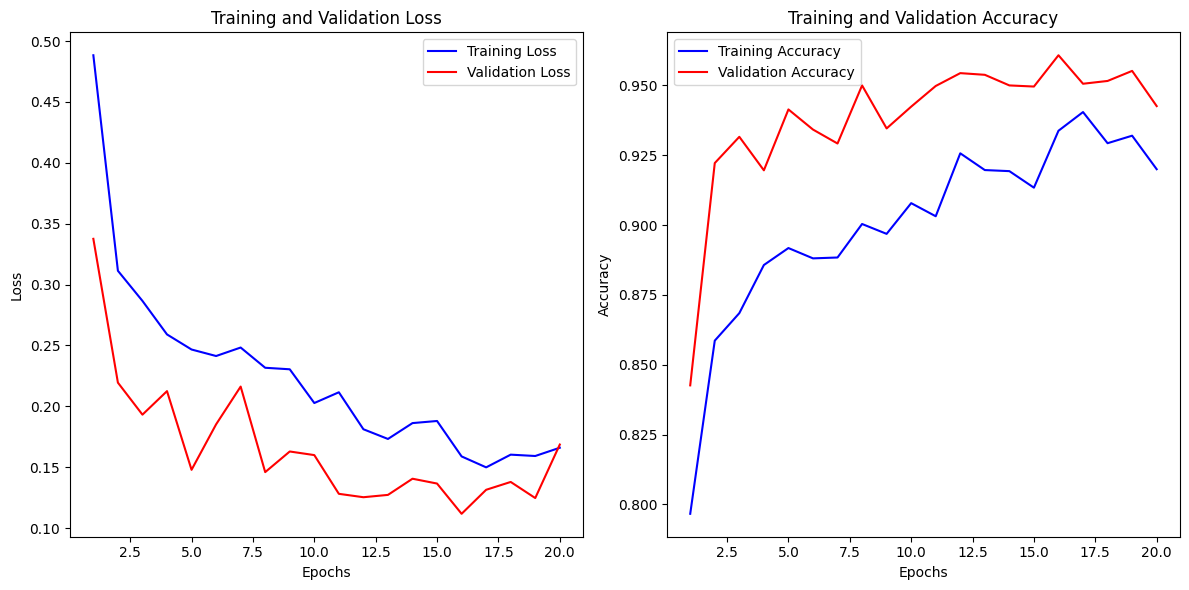

In [21]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy over epochs.
    
    Args:
        history: The history object returned by model.fit().
    """
    # Extract data from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function after training
plot_training_history(history)


In [23]:
model = load_model("testing.h5")


In [27]:
def predict_audio_with_percentage(file_path, model):
    """
    Predict whether an audio file is real or fake using the trained model and print the label and confidence percentage.

    Args:
        file_path (str): Path to the audio file.
        model: Trained Keras model.

    Returns:
        None
    """
    try:
        # Step 1: Load the audio file
        audio, sr = librosa.load(file_path, sr=22050)

        # Step 2: Convert to Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512, n_mels=224)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Normalize and resize to 224x224
        mel_spec_db = librosa.util.normalize(mel_spec_db)
        if mel_spec_db.shape != (224, 224):
            mel_spec_db = librosa.util.fix_length(mel_spec_db, size=224, axis=0)
            mel_spec_db = librosa.util.fix_length(mel_spec_db, size=224, axis=1)

        # Step 3: Expand dimensions to match model input
        mel_spec_db = np.expand_dims(mel_spec_db, axis=(0, -1))  # Shape: (1, 224, 224, 1)

        # Convert single-channel to 3-channel
        mel_spec_db = np.repeat(mel_spec_db, 3, axis=-1)  # Shape: (1, 224, 224, 3)

        print("Input shape for the model:", mel_spec_db.shape)

        # Step 4: Make prediction
        prediction = model.predict(mel_spec_db)
        confidence = float(prediction[0][1])  # Confidence score for "Fake" class

        # Step 5: Interpret the results
        if confidence > 0.5:
            label = "Fake"
            percentage = confidence * 100
        else:
            label = "Real"
            percentage = (1 - confidence) * 100

        # Print the label and confidence percentage
        print(f"Predicted Label: {label}, Confidence: {percentage:.2f}%")

    except Exception as e:
        print(f"Error processing file: {e}")
        return
file_path = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/validation/fake/file1.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav"
predict_audio_with_percentage(file_path, model)


Input shape for the model: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Label: Fake, Confidence: 99.99%
